# Analytics Vidya - Football Hackathon
## by ABIR CHAKRABORTY ( mail2abirchakraborty@gmail.com)


### I have performed the Data exploring and analysis part in R - Studio some key findings i got from there was -
1. The Ratings are not uniformly distributed it needed to take care to prevent biasness towards higher score.
2. There are plenty of Null  and Zero columns which needs to be removed.
3. There are plenty of highly corelated columns  which needs to be removed.
4. The outliers of the numeric column should be treated.

### The Entire solution is divided in following parts
1. Building the first model by Catboost without encoding of the catagorical variables.
2. Building the second model by LGBM with encoding of the catagorical variables.
3. Take the average of the both result as they are expected to find patterns in different way.
4. Treatment of biasness towards highers ratings which is mainly due to presence of higher frequency of rating 10.

In [1]:
# Load the datasets

import pandas as pd
import numpy as np
import math as m

train = pd.read_csv("C:\\Users\\chakr\\Downloads\\train_1K0BDt5\\train.csv")
test = pd.read_csv("C:\\Users\\chakr\\Downloads\\test_kuhCxHY\\test.csv")
ss = pd.read_csv("C:\\Users\\chakr\\Downloads\\sample_submission_wBWLI0s.csv")

In [2]:
x_train = train.drop(['rating_num'], axis = 1)
x_test = test.copy()

In [3]:
# Replace winner,draw, loser with 1,0,-1 in winner column
# Replace team1 with 1 and team2 with zero in team column.

x_train['team'] = np.where(x_train['team']!= 'team1', 1, 0)
x_train['winner'] = np.where(x_train['winner']== 'winner', 1, np.where(x_train['winner']== 'loser', -1,0 ))

x_test['team'] = np.where(x_test['team']!= 'team1', 1, 0)
x_test['winner'] = np.where(x_test['winner']== 'winner', 1, np.where(x_test['winner']== 'loser', -1,0 ))

In [4]:
def remove_outliers(data):
    for col in data:
        high = data[col].mean() + 3*data[col].std()
        low = data[col].mean() - 3*data[col].std()
        data[col] = np.where(
            data[col] > high,
            high,
            np.where(
                data[col] < low,
                low,
                data[col]))
        
remove_outliers(x_train)
remove_outliers(x_test)

In [5]:
y_train = train['rating_num']

In [6]:
# Drop the row_id
all = pd.concat([x_train,x_test])
all = all.drop(['row_id'], axis = 1)

In [7]:
drop_cols = [
    'team2_other_raw_var_19','team1_other_raw_var_50','team1_other_raw_var_72','team1_other_raw_var_19',
    'team1_other_raw_var_31','team1_other_raw_var_33','team1_other_raw_var_92','team1_other_raw_var_82',
    'team2_other_raw_var_72','team1_other_raw_var_38','team1_other_raw_var_40','team1_other_raw_var_43',
    'team2_other_raw_var_92','team1_other_ratio_var_33','team1_other_ratio_var_32','team2_other_raw_var_82',
    'team2_other_raw_var_51','team2_other_raw_var_50','team2_other_raw_var_31','team1_other_raw_var_51',
    'team2_other_ratio_var_32','team2_other_raw_var_33','team2_other_ratio_var_33','team2_other_raw_var_38',
    'team2_other_raw_var_40','team2_other_raw_var_43','player_other_ratio_var_26','player_other_ratio_var_27',
    'player_other_ratio_var_24','player_other_ratio_var_28','player_other_ratio_var_25','player_other_ratio_var_23',
    'player_positional_ratio_var_79','player_other_ratio_var_37','player_defensive_ratio_var_38','player_defensive_ratio_var_39',
    'player_offensive_ratio_var_70','player_offensive_ratio_var_68','player_offensive_ratio_var_69','player_other_ratio_var_67',
    'player_other_ratio_var_73','player_offensive_ratio_var_77','player_other_ratio_var_36','player_defensive_ratio_var_16',
    'player_other_ratio_var_14','player_other_ratio_var_32','player_other_ratio_var_34','player_other_ratio_var_33',
    'player_offensive_ratio_var_72','player_positional_ratio_var_22','player_offensive_ratio_var_78','player_offensive_ratio_var_13',
    'player_other_ratio_var_66','player_offensive_ratio_var_40', 'player_other_ratio_var_7',]
all.drop(drop_cols, axis = 1, inplace = True)

In [8]:
cateogry_columns=all.select_dtypes(include=['object']).columns.tolist()
integer_columns=all.select_dtypes(include=['int64','float64']).columns.tolist()
len(cateogry_columns),len(integer_columns)

(0, 743)

In [9]:
# Replace the NUll values with mean
all = all.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna(x.mode()))

In [10]:
# Change the datatype of charecter columns as charecter.
all['scout_id'] = all['scout_id'].astype(str)
all['team1_system_id'] = all['team1_system_id'].astype(str)
all['team2_system_id'] = all['team2_system_id'].astype(str)
all['competitionId'] = all['competitionId'].astype(str)
all['player_position_1'] = all['player_position_1'].astype(str)
all['player_position_2'] = all['player_position_2'].astype(str)

In [11]:
cateogry_columns=all.select_dtypes(include=['object']).columns.tolist()
cateogry_columns

['scout_id',
 'competitionId',
 'player_position_1',
 'player_position_2',
 'team1_system_id',
 'team2_system_id']

In [12]:
# For next part - Encoded the catagorical columns
all2 = pd.get_dummies(all, drop_first=False)

In [13]:
x_train = all.iloc[0:20453,:]
x_test = all.iloc[20453:,:]

x_train.shape , x_test.shape

((20453, 743), (8774, 743))

In [14]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [15]:
# Drop few more poorly performing columns.

drop_cols = [
    'player_weight','player_offensive_derived_var_24',
 'player_offensive_derived_var_25',
 'player_other_derived_var_42',
 'player_offensive_derived_var_55',
 'player_offensive_derived_var_56',
 'player_positional_derived_var_64',
 'player_other_derived_var_76',
 'player_offensive_derived_var_89',
 'player_offensive_derived_var_90',
 'player_positional_derived_var_100',
 'player_other_derived_var_115',
 'player_offensive_derived_var_128',
 'player_positional_derived_var_136',
 'player_other_raw_var_142',
 'player_other_raw_var_184',
 'player_offensive_derived_var_153',
 'player_offensive_derived_var_151']

x_train.drop(drop_cols, axis = 1, inplace = True)
x_test.drop(drop_cols, axis = 1, inplace = True)


C:\Users\chakr\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# 1st Model -  Catboost without encoding of catagorical variables.

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features =  np.where(x_train.dtypes == object )[0]

model = CatBoostRegressor(iterations=5000)
model.fit(x_train, y_train, cat_features=categorical_features)
test_pred = model.predict(x_test)

ss['rating_num'] = test_pred
#ss.to_csv('football2.csv',index=False)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]


# Feature Importance Plot

Text(0.5, 1.0, 'Feature Importance')

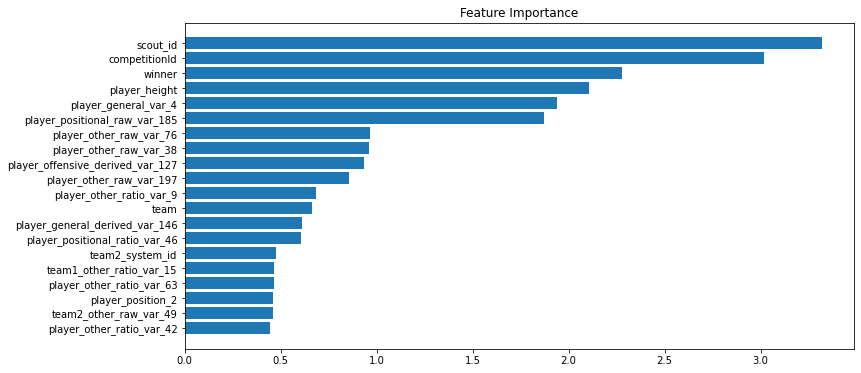

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [19]:
min(test_pred),max(test_pred),test_pred.mean()

(2.0430309026795967, 9.911779202170134, 6.478576922855297)

# 2nd Model -  LGBM with encoding of catagorical variables.

In [20]:
x_train = all2.iloc[0:20453,:]
x_test = all2.iloc[20453:,:]

x_train.shape , x_test.shape

((20453, 867), (8774, 867))

In [21]:
# This is my custom function for LGBM , i used it to get the best parameters

def lgbm_reg(x_train,y_train,x_test,n=10,cv=10,
                learning_rate=[0.01,0.05,0.1,0.3,0.5],
                max_depth= [2,4,6,8,10,12],
                num_leaves= [25,50,100,200],
                reg_lambda=[0.8], 
                reg_alpha=[0.8],
                n_estimators=[50,100,200,500,1000],
                subsample_freq=[1,2,3,4]):

    from sklearn.model_selection import RandomizedSearchCV

    import warnings

    import lightgbm as lgbm

    warnings.filterwarnings('ignore')

    from sklearn.pipeline import Pipeline,FeatureUnion
    from sklearn.base import BaseEstimator, TransformerMixin
    
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")    
    
    
    lgbm_params = {  
                "learning_rate":learning_rate,
                "max_depth":max_depth,
                "num_leaves":num_leaves,
                "n_estimators":n_estimators,
                "reg_lambda":reg_lambda,
                "reg_alpha":reg_alpha,
                "subsample_freq":subsample_freq,
                #"metric":'rmse'
             }
    
    
    lgbm=lgbm.LGBMRegressor()
    n_iter=n

    random_search=RandomizedSearchCV(lgbm,n_jobs=-1,cv=cv,n_iter=n,scoring='r2',
                                 param_distributions=lgbm_params)
    random_search.fit(x_train,y_train)
    report(random_search.cv_results_,5)
    test_pred= random_search.predict(x_test)
    test_pred=test_pred.reshape(len(test_pred),1)
    return(test_pred)    

In [22]:
# Replace with best parameters combination and predict 
import time
start_time = time.time()
lgbm_pred = lgbm_reg(x_train,y_train,
                    x_test,cv=3,n=1,
                   n_estimators=[1000],learning_rate=[0.05],
                   subsample_freq=[2],num_leaves=[100],
                     max_depth=[8],
                    )

ss['rating_num'] = lgbm_pred
#ss.to_csv('football2.csv',index=False)
print("--- %s seconds ---" % (time.time() - start_time))


Model with rank: 1
Mean validation score: 0.219 (std: 0.05355)
Parameters: {'subsample_freq': 2, 'reg_lambda': 0.8, 'reg_alpha': 0.8, 'num_leaves': 100, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05}

--- 261.9574954509735 seconds ---


In [23]:
min(lgbm_pred),max(lgbm_pred),lgbm_pred.mean()

(array([0.62771653]), array([10.1503993]), 6.449695671150239)

In [24]:
lgbm_pred[lgbm_pred>10]=10
min(lgbm_pred),max(lgbm_pred),lgbm_pred.mean()

(array([0.62771653]), array([10.]), 6.449678529674857)

# Take average of both the models

In [25]:
ss['rating_num'] = test_pred.reshape(8774,1)*0.5 + lgbm_pred*0.5
min(ss['rating_num']),max(ss['rating_num']),ss['rating_num'].mean()

(1.428729040656038, 9.649668014365968, 6.4641277262650805)

# Explore Rating Distributions

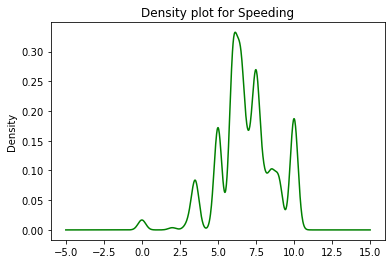

6.0     3654
6.5     3247
7.5     3206
10.0    2442
5.0     2244
7.0     1248
3.5     1077
8.5     1062
9.0     1023
8.0      873
0.0      218
3.0      110
2.0       49
Name: rating_num, dtype: int64

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv("C:\\Users\\chakr\\Downloads\\train_1K0BDt5\\train.csv")

train.rating_num.plot.density(color='green')
plt.title('Density plot for Speeding')
plt.show()

train['rating_num'].value_counts()

####  Even after taking the average of both the models the minimum is still 1.42 , which should be closer to zero. I tried with dropping few rows of training data with Rating 10 and got better score. which proves that the result is getting baised towards higher rating. Eventually i found the below method to reduce that biasness. I started with -1.4 ( minimum of my prediction was -1.42) and gradually changed it with different section. Rating between 5 to 7.5 are treated more finely due to presence of higher number of predictions. Just like parameter tuning had to perform plenty of trial and errors to get what is working best.

In [27]:
ss['rating_num'] = (test_pred.reshape(8774,1)*0.5 + lgbm_pred*0.5)
ss['rating_num'][ss['rating_num']<2]= ss['rating_num'] -1.4
ss['rating_num'][(ss['rating_num']<4) & (ss['rating_num']>=2)]= ss['rating_num']-1.3
ss['rating_num'][(ss['rating_num']<5) & (ss['rating_num']>=4)]= ss['rating_num']-1
ss['rating_num'][(ss['rating_num']<5.25) & (ss['rating_num']>=5)]= ss['rating_num']-0.85
ss['rating_num'][(ss['rating_num']<5.5) & (ss['rating_num']>=5.25)]= ss['rating_num']-0.67
ss['rating_num'][(ss['rating_num']<5.75) & (ss['rating_num']>=5.5)]= ss['rating_num']-0.55
ss['rating_num'][(ss['rating_num']<6) & (ss['rating_num']>=5.75)]= ss['rating_num']-0.42
ss['rating_num'][(ss['rating_num']<6.25) & (ss['rating_num']>=6)]= ss['rating_num']-0.41
ss['rating_num'][(ss['rating_num']<6.5) & (ss['rating_num']>=6.25)]= ss['rating_num']-0.52
ss['rating_num'][(ss['rating_num']<6.75) & (ss['rating_num']>=6.5)]= ss['rating_num']-0.46
ss['rating_num'][(ss['rating_num']<7) & (ss['rating_num']>=6.75)]= ss['rating_num']-0.36
ss['rating_num'][(ss['rating_num']<7.25) & (ss['rating_num']>=7)]= ss['rating_num']-0.40
ss['rating_num'][(ss['rating_num']<7.5) & (ss['rating_num']>=7.25)]= ss['rating_num']-0.54
ss['rating_num'][(ss['rating_num']<8) & (ss['rating_num']>=7.5)]= ss['rating_num']-0.15
ss['rating_num'][(ss['rating_num']<8.5) & (ss['rating_num']>=8)]= ss['rating_num']-0.10
ss['rating_num'][(ss['rating_num']<9) & (ss['rating_num']>=8.5)]= ss['rating_num']-0.20
ss['rating_num'][(ss['rating_num']<11) & (ss['rating_num']>=9)]= ss['rating_num']-0.12


In [28]:
ss.to_csv('football2.csv',index=False)